# Assignment 5:  Topic Models

> net id: sa857

Due: Tuesday, November 5.

This assignment has three problems. The first is about Bayesian inference. The second two are about topic models. You will first work with abstracts of scientific articles. These abstracts are obtained from [arXiv.org](http://arxiv.org), an open access repository for e-prints of articles in scientific fields maintained by Cornell University. You will then work with a collection of movie plots. 

*For your convenience, we have separated the problems into three notebooks: assn5_problem1.ipynb, assn5_problem2.ipynb, and assn5_problem3.ipynb. Submit your solutions in these three notebooks, printing out each as a separate pdf.*

We provide significant "starter code" as discussed in lecture. We then ask you  build topic models using the Python library gensim, and do some analysis over the topics obtained.

We ask that you please at least start the assignment right away. If you have any difficulties running gensim we would like to know!


## Problem 2: Topic models on arXiv abstracts

* The first part of this problem is mainly starter code, showing how to clean up the data. You only need to write some simple functions to remove specific types of words.

* The starter code we provide uses "list comprehensions". Please see the code from lecture if you'd like to see the loop-based versions of this code.

In [1]:
import numpy as np
import pandas as pd
import re
import gensim

from collections import Counter

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.root.level = logging.CRITICAL 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# direct plots to appear within the cell, and set their style
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

The abstracts are in a JSON format in `abstracts.json`. Here is an excerpt from the data we'll be using.

```
{
   "1407.0001": "The topic of finding effective strategy to halt virus in complex network is of current interest. We propose an immunization strategy for seasonal epidemics that occur periodically. Based on the local information of the infection status from the previous epidemic season, the selection of vaccinated nodes is optimized gradually. The evolution of vaccinated nodes during iterations demonstrates that the immunization tends to locate in both global hubs and local hubs. We analyze the epidemic prevalence by a heterogeneous mean-field method and present numerical simulations of our model. This immunization performs superiorly to some other previously known strategies. Our work points out a new direction in immunization of seasonal epidemics.", 
```

We will read this using the `json` package.

In [2]:
import json
with open('abstracts.json') as f:
    data = json.load(f)

The JSON is in a key-value format, where the key is a unique arXiv identifier, and the value is the abstract. We are only concerned with the abstracts, so we will extract them into an array.

*In the next cell and subsequent cells, you will see code commented out. The commented out code has the same functionality as the code prior. The only difference between them is that the commented out ones are written in for loops, while the ones not commented are written using list comprehensions. If you study them, you should be able to understand why they are equivalent!*

In [3]:
sample = 30
abstracts = [item[1] for item in data.items()]
print("Number of documents: %d\n" % len(abstracts))
print(abstracts[sample])

Number of documents: 50000

\noindent A statistical inconsistency of a zero-inflated Binomial likelihood model for count data is identified. This issue occurs when the response, $y$, is both zero and n-inflated, and results in statistically inconsistent and erroneous parameter inferences being drawn from the data. The zero-modified Binomial likelihood is amended to address this issue of \textit{n-inflation}, resulting in a fully symmetric Binomial likelihood model for both zero and n-inflated counts. We present a simple regression example from the ecological literature which details the practical application of the new likelihood model.


This abstract is from article [arXiv:1407.0064v1](https://arxiv.org/abs/1407.0064v1) on the arXiv. From the sample document, we see that the abstracts can have various marked up text such as `\noindent`, `$y$`, or `\textit{n-inflation}`. This is LaTeX, a text markup system that allows for more convenient scientific technical writing. For example, the text `\sum_{i=1}^ni = \frac{n(n+1)}{2}` is processed to

$$\sum_{i=1}^ni = \frac{n(n+1)}{2}$$

LaTeX is widely used in academia across fields like statistics, computer science, linguistics and political science.

For our purposes, we have to remove such markup as we only want to process natural text. We can once again use regular expressions to remove the markup.

In [4]:
# remove $...$ or $$...$$ math markup
abstracts = [re.sub(r'\$\$.*?\$\$', r'', abstract) for abstract in abstracts]
abstracts = [re.sub(r'\$.*?\$', r'', abstract) for abstract in abstracts]

# remove \emph{...}, \textit{...} type markup and replace with ...
abstracts = [re.sub(r'\\\S*?\{(.*?)\}', r'\1', abstract) for abstract in abstracts]

# remove \noindent type markup
abstracts = [re.sub(r'\\(\S*)', r'', abstract) for abstract in abstracts]

# remove {{...}}, {...}, and (...) markup, and replace with ...
abstracts = [re.sub(r'\{\{(.*?)\}\}', r'\1', abstract) for abstract in abstracts]
abstracts = [re.sub(r'\{(.*?)\}', r'\1', abstract) for abstract in abstracts]
abstracts = [re.sub(r'\((.*?)\)', r'\1', abstract) for abstract in abstracts]

# replace '-' with ' ', then remove punctuation
abstracts = [re.sub(r'-', ' ', abstract) for abstract in abstracts]
abstracts = [re.sub(r'[^\w\s]', '', abstract) for abstract in abstracts]

print(abstracts[sample])

 A statistical inconsistency of a zero inflated Binomial likelihood model for count data is identified This issue occurs when the response  is both zero and n inflated and results in statistically inconsistent and erroneous parameter inferences being drawn from the data The zero modified Binomial likelihood is amended to address this issue of n inflation resulting in a fully symmetric Binomial likelihood model for both zero and n inflated counts We present a simple regression example from the ecological literature which details the practical application of the new likelihood model


Now, we want to further process each abstract by converting it to lower case, stripping leading and trailing white space, and then tokenizing by splitting on spaces.

In [5]:
abstracts_tok = [abstract.lower().strip().split(' ') for abstract in abstracts]


We will further remove tokens that have digits, have possessives or contractions, or are empty strings.

### 2.1 Removing special strings

Write functions that will achieve that functionality described. Specifically, write
- `is_numeric(string)` which checks if `string` has any numbers
- `has_poss_contr(string)` which checks if `string` has possessives or contractions
- `empty_string(string)` which checks if `string` is an empty string
- `remove_string(string)` which checcks if `string` should be removed

In [6]:
def is_numeric(string):
    return bool(re.search('\d', string))

In [12]:
def has_poss_contr(string):
    blacklist_in = ["'s", "'m", "'re", "'ve", "'d", "'ll", "'t"]
    return any(i in string for i in blacklist_in)

In [15]:
def empty_string(string):
    return not bool(string)

In [20]:
def remove_string(string):
    return is_numeric(string) or has_poss_contr(string) or empty_string(string)

In [21]:
abstracts_tok = [[token for token in abstract if not remove_string(token)] for abstract in abstracts_tok]


Topic modelling is a collection of powerful statistical methods for discovering abstract "topics" that occur in a collection of documents. The overall intuition behind topic models is that each document is only about a few topics, and similar documents contain similar words. 

For example, the two documents below are similar because over the entire vocabulary of words, they contain similar frequently appearing words like "complex", "network", "epidemic".

```
{
   "1407.0001": "The topic of finding effective strategy to halt virus in complex network is of current interest. We propose an immunization strategy for seasonal epidemics that occur periodically. Based on the local information of the infection status from the previous epidemic season, the selection of vaccinated nodes is optimized gradually. The evolution of vaccinated nodes during iterations demonstrates that the immunization tends to locate in both global hubs and local hubs. We analyze the epidemic prevalence by a heterogeneous mean-field method and present numerical simulations of our model. This immunization performs superiorly to some other previously known strategies. Our work points out a new direction in immunization of seasonal epidemics.", 
```

```
  "1407.0774": "The spread of disease on complex networks has attracted widely attention in the physics community. Recent works have demonstrated that heterogeneous degree and weight distributions have a significant influence on the epidemic dynamics. In this study, a novel edge-weight based compartmental approach is developed to estimate the epidemic threshold and epidemic size (final infected density) on networks with general degree and weight distributions, and a remarkable agreement with numerics is obtained. Even in complex network with the strong heterogeneous degree and weight distributions, this approach is worked. We then propose an edge-weight based removal strategy with different biases, and find that such a strategy can effectively control the spread of epidemic when the highly weighted edges are preferentially removed, especially when the weight distribution of a network is extremely heterogenous. The theoretical results from the suggested method can accurately predict the above removal effectiveness.", 
```

To build topic models, we require the following components:
- A *vocabulary of tokens* that appear across all documents.
- A *mapping of tokens to a unique integer identifier*, because topic model algorithms treat words by these identifiers, and not by the strings themselves. For example, we represent `'epidemic'` as `word2id['epidemic'] = 50`
- A *corpus*, where each document in the corpus is a collection of tokens, where each token is represented by the identifier and the number of times it appears in the document. For example, in the first document above the token `'epidemic'`, which appears twice, is represented as `(50, 2)`

First, we will build a vocabulary representing the tokens that have appeared across all the abstracts we have. When doing this, we typically want to (1) remove rare words, (2) remove stop words and (3) stem/lemmatize words (which we will not do).

To do this, we can use the `Counter` class. The `Counter` is an extension of the Python dictionary which is a set of key-value pairs. For the `Counter` class, keys are the objects to be counted, while values are their counts.

In [22]:
vocab = Counter()
for abstract in abstracts_tok:
    vocab.update(abstract)

print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 75970


Removing rare words helps prevent our vocabulary from being too large. Many tokens appear only a few times across all the abstracts. Keeping them in the vocabulary increases subsequent computation time. Furthermore, their presence tends not to carry much significance for a document, since they can be considered as anomalies.

We remove rare words by only keeping tokens that appear more than 25 times across all abstracts

In [23]:
vocab = Counter(token for token in vocab.elements() if vocab[token] > 25)
print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 10480


Stop words are defined as very common words such as `'the'` and `'a'`. Removing stop words is important because their presence also does not carry much significance, since they appear in all kinds of texts.

We will remove stop words by removing the 200 most common tokens across all abstracts

In [24]:
stop_words = [item[0] for item in vocab.most_common(200)]
vocab = Counter(token for token in vocab.elements() if token not in stop_words)
print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 10280


Now we create a mapping for tokens to unique identifiers. 

In [25]:
id2word = {idx: pair[0] for idx, pair in enumerate(vocab.items())}
word2id = {pair[0]: idx for idx, pair in enumerate(vocab.items())}

print("Number of tokens mapped: %d" % len(id2word))
print("Identifier for 'epidemic': %d" % word2id['epidemic'])
print("Word for identifier %d: %s" % (word2id['epidemic'], id2word[word2id['epidemic']]))

Number of tokens mapped: 10280
Identifier for 'epidemic': 15
Word for identifier 15: epidemic


Now, we will remove, for each abstract, the tokens that are not found in our vocabulary.

In [28]:
abstracts_tok = [[token for token in abstract if token in vocab] for abstract in abstracts_tok]


Let's create the corpus. Recall that for the tokens in an abstract:

```
['statistical', 'inconsistency', 'binomial', 'likelihood', 'count', 'identified.', 'issue', 'occurs', 'when', 'response,', 'zero', 'statistically', 'inconsistent', 'erroneous', 'parameter', 'inferences', 'being', 'drawn', 'data.', 'binomial', 'likelihood', 'address', 'issue', 'resulting', 'fully', 'symmetric', 'binomial', 'likelihood', 'zero', 'counts.', 'present', 'simple', 'regression', 'example', 'ecological', 'literature', 'details', 'practical', 'application', 'likelihood', 'model.']
```
the corpus has the format
```
[(1396, 1), (1397, 1), (1398, 3), (1399, 4), (1400, 1), (1401, 1), (1402, 2), (1403, 1), (591, 1), (672, 1), (34, 2), (1404, 2), (1405, 1), (1406, 1), (1407, 1), (444, 1), (1408, 1), (1409, 1), (1410, 1), (1187, 1), (610, 1), (1411, 1), (857, 1), (1412, 1), (41, 1), (554, 1), (1413, 1), (1414, 1), (1415, 1), (1416, 1), (1205, 1), (91, 1), (945, 1)]
```

where each element is a pair containing the identifier for the token and the count of that token in just that abstract.

In [29]:
corpus = []
for abstract in abstracts_tok:
    abstract_count = Counter(abstract)
    corpus.append([(word2id[item[0]], item[1]) for item in abstract_count.items()])

print("Abstract, tokenized:\n", abstracts_tok[sample], "\n")
print("Abstract, in corpus format:\n", corpus[sample])

Abstract, tokenized:
 ['statistical', 'inconsistency', 'zero', 'inflated', 'binomial', 'likelihood', 'count', 'identified', 'issue', 'occurs', 'response', 'zero', 'n', 'inflated', 'statistically', 'inconsistent', 'erroneous', 'inferences', 'being', 'drawn', 'zero', 'modified', 'binomial', 'likelihood', 'address', 'issue', 'n', 'inflation', 'resulting', 'fully', 'symmetric', 'binomial', 'likelihood', 'zero', 'n', 'inflated', 'counts', 'regression', 'example', 'ecological', 'literature', 'details', 'practical', 'application', 'likelihood'] 

Abstract, in corpus format:
 [(1204, 1), (1205, 1), (1206, 4), (1207, 3), (1208, 3), (1209, 4), (1210, 1), (1211, 1), (1212, 2), (1213, 1), (555, 1), (1131, 3), (1214, 1), (1215, 1), (1216, 1), (1217, 1), (1218, 1), (1219, 1), (464, 1), (1017, 1), (1220, 1), (505, 1), (1221, 1), (722, 1), (1222, 1), (1223, 1), (1224, 1), (1225, 1), (1226, 1), (1034, 1), (68, 1), (797, 1)]


## Building a topic model

Now, we are ready to create our topic model!

We will use gensim, a Python library to create topic models. We will use the algorithm called latent dirichlet allocation implemented in the gensim library. 

**This step takes some time (about 4 min)**

In [31]:
#%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

After building the topic model, we want to view the 10 topics. The topics are represented as a combination of keywords with corresponding weight on the keyword. Note that the order of these topics can change between different training runs of the topic model, since there is no ordering between topics and gensim returns them in an arbitrary order.

In [32]:

num_topics = 10
num_words = 15
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = lda_model.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

top_words


,word rank,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,1,bound,boundary,spectral,classical,light,flow,multiple,interaction,algorithms,deep
1,2,matter,approximation,spectrum,cluster,frequency,points,noise,interactions,neural,ray
2,3,dark,graphs,region,out,topological,groups,existing,critical,image,observations
3,4,lower,nonlinear,measurements,stable,induced,dimension,techniques,particle,applications,x
4,5,task,existence,line,those,scalar,spaces,multi,symmetry,control,star
5,6,radio,convergence,velocity,similar,gravity,symmetric,scheme,lattice,classification,galaxies
6,7,upper,operator,resolution,so,optical,algebra,communication,electron,novel,emission
7,8,decay,derive,family,fields,modes,theorem,available,scattering,training,sample
8,9,generation,second,ratio,black,physics,metric,action,dependent,optimization,gas
9,10,core,positive,stability,initial,measurement,representation,compared,particles,accuracy,formation


We can compute the probability distribution for a given abstract in the `corpus`. This represents how likely it is for the abstract to belong to each topic.

In [33]:
sample = 10
lda_model.get_document_topics(corpus[sample])

[(0, 0.05851045),
 (1, 0.07150707),
 (2, 0.019132039),
 (3, 0.046507437),
 (4, 0.02102072),
 (6, 0.011875552),
 (7, 0.076684006),
 (8, 0.061220784),
 (9, 0.6250374)]

Let's represent this as a table.

In [34]:
topic_dist = lda_model.get_document_topics(corpus[sample])
topics = [pair[0] for pair in topic_dist]
probabilities = [pair[1] for pair in topic_dist]
topic_dist_table = pd.DataFrame()
topic_dist_table['Topic'] = topics
topic_dist_table['Probabilities'] = probabilities
topic_dist_table

,Topic,Probabilities
0,0,0.058510
1,1,0.071506
2,2,0.019140
3,3,0.046509
4,4,0.021021
5,6,0.011861
6,7,0.076686
7,8,0.061221
8,9,0.625040


In [35]:
t = np.argmax(probabilities)
print("Topic with highest probability: %d (%f)" % (t, probabilities[t]))

Topic with highest probability: 8 (0.625040)


And now as a histogram.

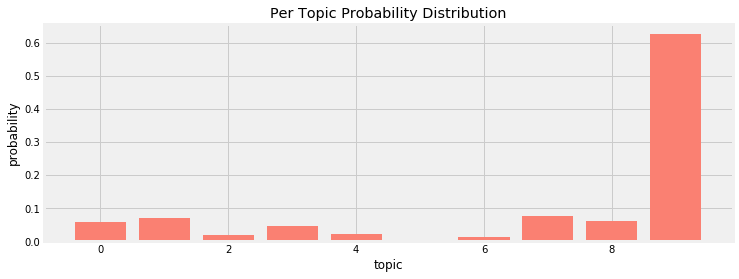

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(11,4)
plt.bar(topic_dist_table['Topic'], topic_dist_table['Probabilities'], align='center', alpha=1, color='salmon')
plt.xlabel('topic')
plt.ylabel('probability')
plt.title('Per Topic Probability Distribution')
plt.show()

So it seems the document

```
  "1407.0034": "We use cosmological simulations to assess how the explosion of the first stars in supernovae (SNe) influences early cosmic history. Specifically, we investigate the impact by SNe on the host systems for Population~III (Pop~III) star formation and explore its dependence on halo environment and Pop~III progenitor mass. We then trace the evolution of the enriched gas until conditions are met to trigger second-generation star formation. To this extent, we quantify the recovery timescale, which measures the time delay between a Pop~III SN explosion and the appearance of cold, dense gas, out of which second-generation stars can form. We find that this timescale is highly sensitive to the Pop~III progenitor mass, and less so to the halo environment. For Pop~III progenitor masses, $M_{\\ast}=15{{\\,M_\\odot}}$, $25{{\\,M_\\odot}}$, and $40{{\\,M_\\odot}}$ in a halo of $5\\times10^5{{\\,M_\\odot}}$, recovery times are $\\sim10$\\,Myr, $25$\\,Myr, and $90$\\,Myr, respectively. For more massive progenitors, including those exploding in pair instability SNe, second-generation star formation is delayed significantly, for up to a Hubble time. The dependence of the recovery time on the mass of the SN progenitor is mainly due to the ionizing impact of the progenitor star. Photoionization heating increases the gas pressure and initiates a hydrodynamical response that reduces the central gas density, an effect that is stronger in more massive. The gas around lower mass Pop~III stars remains denser and hence the SN remnants cool more rapidly, facilitating the subsequent re-condensation of the gas and formation of a second generation of stars. In most cases, the second-generation stars are already metal-enriched to $\\sim2-5\\times10^{-4}{{\\rm \\,Z_\\odot}}$, thus belonging to Population~II. The recovery timescale is a key quantity governing the nature of the first galaxies, able to host low-mass, long-lived stellar systems. These in turn are the target of future deep-field campaigns with the {\\it James Webb Space Telescope}.", 
```

has the greatest likelihood to fall under the topic number with topic relating to cosmology, which matches our intuition.

## Topics for Abstracts

*Your turn!* Your task is broken down into three parts

#### 2.2 Label the Topics
Label all the 10 topics with your interpretation of what the topics are. This may not come naturally since we are dealing with scientific articles, but do your best! Incorporate the labels by changing the names of the columns in the `top_words` table above. Also form a new table `labels` with 2 columns, where the column names are `topic_num` and `topic_label`

In [74]:
mapTopicsToLabels = {
    0 : "dark matter", 
    1 : "graph theory",
    2 : "light measurment", 
    3 : "classical physics", 
    4 : "black holes",
    5 : "maximum flow problem", 
    6 : "noisy communication",
    7 : "wave-particle interaction",
    8 : "image classification",
    9 : "cosmology",
}

In [90]:
new_names = ["word rank"] + [v for v in mapTopicsToLabels.values()]
top_words.columns=new_names
top_words

,word rank,dark matter,graph theory,light measurment,classical physics,black holes,maximum flow problem,noisy communication,wave-particle interaction,image classification,cosmology
0,1,bound,boundary,spectral,classical,light,flow,multiple,interaction,algorithms,deep
1,2,matter,approximation,spectrum,cluster,frequency,points,noise,interactions,neural,ray
2,3,dark,graphs,region,out,topological,groups,existing,critical,image,observations
3,4,lower,nonlinear,measurements,stable,induced,dimension,techniques,particle,applications,x
4,5,task,existence,line,those,scalar,spaces,multi,symmetry,control,star
5,6,radio,convergence,velocity,similar,gravity,symmetric,scheme,lattice,classification,galaxies
6,7,upper,operator,resolution,so,optical,algebra,communication,electron,novel,emission
7,8,decay,derive,family,fields,modes,theorem,available,scattering,training,sample
8,9,generation,second,ratio,black,physics,metric,action,dependent,optimization,gas
9,10,core,positive,stability,initial,measurement,representation,compared,particles,accuracy,formation


In [75]:
labels = pd.DataFrame(
    zip(mapTopicsToLabels.keys(), mapTopicsToLabels.values()),
    columns=["topic_num", "topic_label"])

In [76]:
labels

,topic_num,topic_label
0,0,dark matter
1,1,graph theory
2,2,light measurment
3,3,classical physics
4,4,black holes
5,5,maximum flow problem
6,6,noisy communication
7,7,wave-particle interaction
8,8,image classification
9,9,cosmology


#### 2.3 Table of Topics for Abstracts
Create a function `create_topic_table(data, abstracts, corpus, lda_model)` which does the following:
- Goes through every abstract in the word-index form `corpus`, finding the most likely topic for that abstract
- Creates a table `topic_table` that has the following columns
    - `arxiv id`: the arXiv document number of each abstract
    - `topic`: the topic number of the most likely topic for each abstract
    - `label`: the topic label of that topic number, which you assigned in part 1
    - `prob`: the probability of that topic number for each abstract
    - `abstract`: a string containing the first 200 characters of the abstract
- Show the first 10 rows of the table, then return the table

You can refer to the function skeleton below.

In [93]:
def create_topic_table(data, abstracts, corpus, lda_model):
    
    # retrieve the arXiv ids by iterating over data.items()
    
    # retrieve the topic numbers, labels and probabilities
    # for each abstract in the corpus, 
    # - find the topic distribution for the abstract
    # - get the topic number with highest probability,
    # - get the topic label associated with tthee topic number
    # - get the label for that topic
    
    # create table with
    # - column of arXiv ids
    # - column of topic numbers
    # - column of topic labels
    # - columnn of topic probabilities of that topic
    # - column of text for the abstract
    
    # show first 10 rows of the table 
    # return the table
    
    # Here is some sample code you could use to get started:
    arxiv_id = [item[0] for item in data.items()]
    
    
    # initialize some arrays
    probs = []
    topic = []
    label = []
    short_abstract = []
    for sample in np.arange(len(corpus)):
        short_abstract.append(abstracts[sample][0:200])
        
        # Now find the most probable topic by calling 
        topic_dist = lda_model.get_document_topics(corpus[sample])
        _topics = [pair[0] for pair in topic_dist]
        _probabilities = [pair[1] for pair in topic_dist]
        
        # Try using np.argmax
        _t = np.argmax(_probabilities)
        probs.append(_probabilities[_t])
        topic.append(_topics[_t])
        label.append(mapTopicsToLabels[_topics[_t]])
        
    table = pd.DataFrame()
    table['arxiv id'] = arxiv_id # attach the entire column
    table['abstract'] = short_abstract # attach the entire column
    table['topic'] = topic
    table['label'] = label
    table['prob'] = probs
    # You'll need to add the topic, label, and probability for each abstract
    return table

In [94]:
topic_table = create_topic_table(data, abstracts, corpus, lda_model)
topic_table.head(20)

,arxiv id,abstract,topic,label,prob
0,1407.0001,The topic of finding effective strategy to hal...,9,cosmology,0.323206
1,1407.0004,Linear precoding exploits the spatial degrees ...,6,noisy communication,0.499424
2,1407.0016,We present completed observations of the NGC 7...,9,cosmology,0.444528
3,1407.0017,Increasingly stringent limits from LHC searche...,0,dark matter,0.224427
4,1407.0023,Results are presented for an initial survey of...,9,cosmology,0.397316
5,1407.0026,Current time domain wide field sky surveys gen...,9,cosmology,0.522321
6,1407.0029,Spinless fermions on a honeycomb lattice provi...,7,wave-particle interaction,0.614909
7,1407.0030,3pt The strong CP violating parameter is sma...,4,black holes,0.588786
8,1407.0031,Cross correlating the Planck High Frequency In...,9,cosmology,0.408977
9,1407.0033,We study low energy effective field theories f...,7,wave-particle interaction,0.272530


#### 2.4 Analysis for selected abstracts
Choose at least five articles and discuss how the assignment of topics either does or does not make sense, according to your own understanding of the article.
Include your comments in a Markdown cell, with code cells added as needed to pull out particular rows of your table. Note that you can see the original scientific article a given `<arxiv id>` by visiting the web site `http://arxiv.org/abs/<arxiv id>`.  For example, [http://arxiv.org/abs/1407.0001](http://arxiv.org/abs/1407.0001) shows the first paper in the table.

In [96]:
# i chose a random selection of 5
topic_table.iloc[30:35]

,arxiv id,abstract,topic,label,prob
30,1407.0064,A statistical inconsistency of a zero inflate...,1,graph theory,0.296635
31,1407.0065,We describe a novel approach for generating li...,3,classical physics,0.435041
32,1407.0071,We propose a quantum mechanical method of dete...,4,black holes,0.409316
33,1407.0073,We present a femtosecond optical pump probe st...,7,wave-particle interaction,0.710915
34,1407.0077,The wavefunction method provides us with a use...,7,wave-particle interaction,0.693140


- 30: it is actually about statistical methodology, which is quite close to what I had in mind when I wrote graph theory. In other words, it focuses on the theoretical mathematics, rather than any empirical research.
- 31: it is actually a subbranch of physics called optics
- 32: it is about quantum physics, not black holes
- 33: it is about correlated electrons, which is a very arcane subject, but ostensibly related to wave-particles
- 34: it is the same as 33

In summary, all topics are quite close, but describe another underlying facet of the data which would have been more clear to me if I was not a layperson and knew some more physics to describe the topics

#### 2.5 Extra credit: Improve the model
For extra credit, improve the topic model by improving the processing of the data and the vocabulary, and selecting a more appropriate number of topics. Describe how your new model gives an improvement over the "quick and dirty" topic model built above.